# Can we really map the space of genre?

Maps of genre are very popular. Some of them are fanciful.

<br>

<img src="files/movieland.png">

<br>

Others, like the website [Every Noise at Once](http://everynoise.com/engenremap.html?ref=producthunt), try to represent the distance between musical genres in some abstract feature space extracted from the music itself, and compressed down to two dimensions.

<br>

<img src="files/everynoisedetail.png">

But is it really possible to map the space of genre? To put that more concretely, how do we know there is a universal "distance metric" for cultural phenomena? Mathematically, distance metrics are supposed to obey certain rules. For instance

    A -> B >= 0  (distances are not negative!)
    A -> B == B -> A   (symmetry) and
    (A -> B) + (B -> C) >= A -> C (triangle inequality)

But maybe the distances between genres A, B, and C depend on whether you're standing at A, B, or C? Or at any rate, maybe the criteria of similarity vary depending on the pair of genres you're comparing?

If that's true, the similarities and differences between genres aren't distances in a strict mathematical sense, and can't really be represented on a map (even setting aside the difference between high-dimensional space and a 2D plane).

How can we know whether this is true? What would we do if it *was* true?

In [1]:
import csv, random
import pandas as pd
import numpy as np
import math, sys
from collections import Counter
from scipy import spatial
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
from sklearn.manifold import MDS
# import statsmodels.api as sm

## 1. The plan of the experiment.

We know that certain measures of textual similarity do behave like distances: for instance, if we measure Euclidean distances in vector space, they are 100% guaranteed to behave like a distance metric. Cosine distances are more ambiguous: they don't obey the triangle inequality. 

On the other hand, if we train classifiers to recognize genres, we will have a measure of similarity closely tied to the identity of specific genres that is not *at all* guaranteed to behave like distance: as we will see in a moment, classifier accuracy may not even obey the rule of symmetry: it can be farther from A to B than it is from B to A.

We want to test these different measures of textual similarity, and see which ones correspond most closely to other intuitions about the proximity of genres. So we need a measure of proximity that isn't based in textual comparison. The measure we choose probably won't be infallible, but it should at least be independent of textual similarity.

## 2. A social measure of similarity.

For instance, we could use library metadata. If two genre/form/subject headings are often assigned to the same books, we might infer that they're related.

In [the experiment I'm retracing here,](http://aclweb.org/anthology/W18-4507) I used both "subject" headings (which began to be assigned relatively early in the history of the Library of Congress system), and "genre" headings, which only got added toward the end of the 20th century.

I measured the overlap between headings using the [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) of their co-association with volumes:
 
    log(p(x, y) / p(x)p(y)).

Where p(x) is, for instance, the probability that a volume is labeled "Humor," p(y) the probability that a volume is labeled "Horror," and p(x, y) the probability that the same volume is labeled "Humor" and "Horror." The number will be higher if two headings frequently occur together

There are a lot of messy details involved in the actual calculation, and running it takes more than half an hour, because I'm using a large collection of volumes from HathiTrust. So I won't try to recreate it all in this workshop; we'll just load a pre-computed similarity matrix. If you want to see how the computation was done, [the notebook is on github.](https://github.com/tedunderwood/genredistance/blob/master/select_data/build_genre_dataset.ipynb)

In [2]:
# Load the pre-computed matrix ...

social = pd.read_csv('../socialmeasures/pmidf.csv', index_col = 'index')

# and take a look at it:

social

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
index,,,,,,,,,,,,,,,,,,,,,
Adventure,4.279903,0.435610,0.343080,0.221690,0.305965,0.588636,1.379508,-3.243798,1.227815,1.130951,...,-2.400227,0.936398,0.441526,-2.845089,1.117171,-2.666464,-3.010117,-1.688237,0.795667,-2.159260
Bildungsroman,0.435610,4.053356,-3.165622,1.131953,1.720973,-0.694249,1.093455,-0.328167,1.701955,-3.335126,...,-2.928306,-3.135787,0.821285,-3.273126,-2.619720,-3.338657,-3.604928,-0.693552,2.265967,0.977699
Biographical,0.343080,-3.165622,4.916599,3.110273,0.009942,-2.894851,2.114180,-2.517358,-2.962145,-1.474224,...,-1.756554,-1.443649,-2.944366,-2.256043,-1.651594,-2.421566,-2.428072,-3.985702,1.844265,2.425606
Christian,0.221690,1.131953,3.110273,5.416200,1.049163,2.156130,1.000321,-2.123703,-2.363184,-1.696563,...,-1.407832,-1.033527,1.248363,-1.256016,-1.016478,-1.682466,-1.673172,-0.660272,-1.463414,-0.668447
Domestic,0.305965,1.720973,0.009942,1.049163,3.189220,-2.378864,1.054664,-1.374636,0.861812,-4.720872,...,-3.603519,-4.332381,1.263024,-3.971152,-3.427581,-1.001827,-4.536183,-0.428196,0.661536,0.218978
Fantasy,0.588636,-0.694249,-2.894851,2.156130,-2.378864,4.234711,0.909377,2.179593,0.245513,-0.639921,...,-2.528873,-2.494904,0.011914,-0.423531,0.611025,-3.223219,-3.228188,0.249198,-0.496345,-2.330399
Historical,1.379508,1.093455,2.114180,1.000321,1.054664,0.909377,3.489242,0.085551,-1.092102,-1.965720,...,-3.201279,-3.927214,0.290489,-3.801247,-3.134623,-4.045185,-4.163451,0.117043,2.682408,1.667594
Horror,-3.243798,-0.328167,-2.517358,-2.123703,-1.374636,2.179593,0.085551,4.612799,-3.410408,-2.254403,...,-2.001259,-1.756085,-3.296209,-2.493054,-1.911615,-2.608324,-0.432951,0.245167,-2.487540,0.969952
Humor,1.227815,1.701955,-2.962145,-2.363184,0.861812,0.245513,-1.092102,-3.410408,4.089647,-0.521751,...,4.089647,-0.587908,1.357892,-2.979538,-2.398768,-3.169652,-3.294340,-0.207172,-2.925803,-2.301749


### 2.1 Convert PMI to a distance matrix.

It's not exactly easy to inspect a 32 x 32 matrix and draw conclusions. We can see that the central diagonal has the highest measures of similarity (which makes sense, because A == A), but not always the same values (which is odd, because A is always == A). 

But we can't say much else.

To make this easier to understand, let's compress the matrix to a 2D plane. This will involve some distortion. Right now the genres are represented in 32-dimensional space. We're going to compress that down to two dimensions using multidimensional scaling.

In [3]:
# Several mechanical transformations are necessary first. MDS expects 
# a matrix of distances, but we have a matrix of PMI values, which
# are similarities rather than distances (higher is more *similar*, and
# values can be negative). We can address that by first making
# the matrix positive.

negativepart = social.values.min()
vizmatrix = social - negativepart

# And then subtracting similarities from the maximum similarity so that
# we get instead a matrix of distances. (Maximum similarity will now
# be a distance of zero.)

maximumvalue = vizmatrix.values.max()
vizmatrix = maximumvalue - vizmatrix

# Plus, in a distance matrix, *all* the diagonal values are zero.

for idx in vizmatrix.index:
    vizmatrix.loc[idx, idx] = 0

What does the matrix look like now?

In [4]:
vizmatrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
index,,,,,,,,,,,,,,,,,,,,,
Adventure,0.000000,5.136092,5.228622,5.350013,5.265737,4.983066,4.192194,8.815500,4.343887,4.440752,...,7.971930,4.635304,5.130176,8.416791,4.454531,8.238166,8.581819,7.259939,4.776035,7.730962
Bildungsroman,5.136092,0.000000,8.737324,4.439749,3.850730,6.265951,4.478247,5.899869,3.869747,8.906828,...,8.500008,8.707489,4.750417,8.844828,8.191423,8.910359,9.176630,6.265254,3.305735,4.594003
Biographical,5.228622,8.737324,0.000000,2.461429,5.561760,8.466553,3.457522,8.089060,8.533847,7.045926,...,7.328256,7.015351,8.516068,7.827745,7.223296,7.993268,7.999774,9.557404,3.727437,3.146096
Christian,5.350013,4.439749,2.461429,0.000000,4.522540,3.415573,4.571381,7.695405,7.934886,7.268265,...,6.979534,6.605230,4.323340,6.827718,6.588180,7.254168,7.244874,6.231974,7.035116,6.240149
Domestic,5.265737,3.850730,5.561760,4.522540,0.000000,7.950566,4.517038,6.946338,4.709890,10.292574,...,9.175221,9.904083,4.308678,9.542854,8.999283,6.573529,10.107885,5.999898,4.910166,5.352724
Fantasy,4.983066,6.265951,8.466553,3.415573,7.950566,0.000000,4.662325,3.392109,5.326189,6.211623,...,8.100575,8.066606,5.559789,5.995234,4.960678,8.794921,8.799890,5.322504,6.068047,7.902101
Historical,4.192194,4.478247,3.457522,4.571381,4.517038,4.662325,0.000000,5.486151,6.663804,7.537423,...,8.772981,9.498916,5.281213,9.372949,8.706325,9.616887,9.735153,5.454659,2.889295,3.904108
Horror,8.815500,5.899869,8.089060,7.695405,6.946338,3.392109,5.486151,0.000000,8.982110,7.826105,...,7.572961,7.327787,8.867911,8.064756,7.483317,8.180027,6.004653,5.326535,8.059242,4.601750
Humor,4.343887,3.869747,8.533847,7.934886,4.709890,5.326189,6.663804,8.982110,0.000000,6.093453,...,1.482055,6.159610,4.213810,8.551240,7.970470,8.741354,8.866042,5.778874,8.497506,7.873451


In [7]:
# Now finally we're ready to turn the matrix into
# x, y coordinates:
    
scaler = MDS(metric = True, dissimilarity = 'precomputed')
coordinates = scaler.fit_transform(vizmatrix)

Note that there are several other ways we could have carried out the conversion above. E.g., we could have scaled the matrix so each column or row has the same variance. In the workshop it may be worth playing around with other alternatives to see how much difference they make.

### 2.2 Visualize the MDS-transformed relationships.

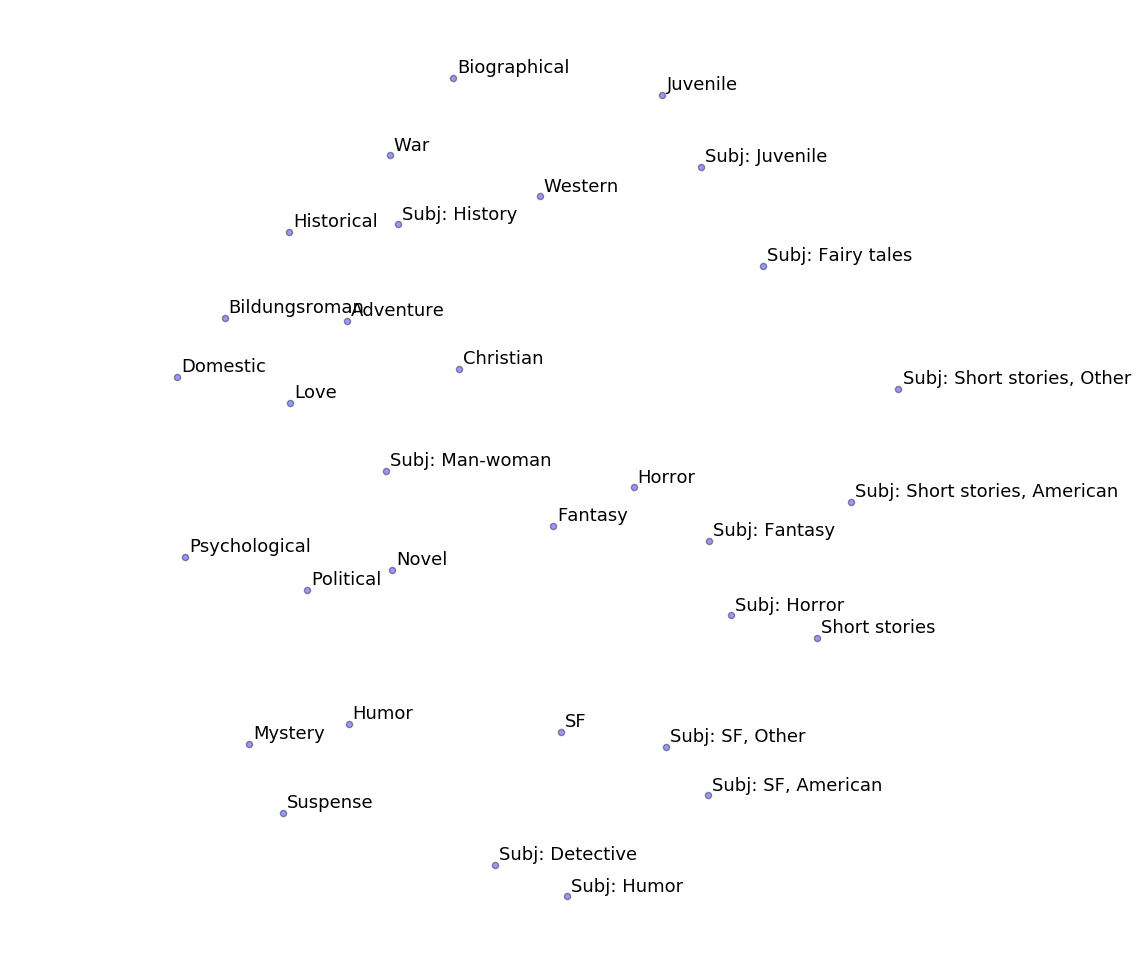

In [10]:
fig, ax = plt.subplots(figsize = (12, 12))
genres = vizmatrix.index.tolist()
colors=np.linspace(0, 1, 7)
ax.scatter(coordinates[ :, 0], coordinates[ : , 1], alpha = 0.4)

for i in range(len(genres)):
    thisx = coordinates[i, 0]
    thisy = coordinates[i, 1]
    name = genres[i]
    ax.annotate(name, (thisx + 0.07, thisy + 0.07), fontsize = 13)
    
plt.axis('off')
plt.show()

Is that a plausible map of genre?

## 3. Tf-idf distances between genres

Now let's start to compare various textual measures of similarity to our social benchmark, keeping in mind that the social evidence is not necessarily a gold standard. It's just something non-textual we can use as a point of comparison.

Let's start with a fairly naive approach. We'll reduce each genre to a vector of 10,000 word frequencies, and adjust the word frequencies for inverse document frequency using [a strategy commonly applied in information retrieval.](https://en.wikipedia.org/wiki/Karen_Spärck_Jones) The term of art for vectors adjusted this way is term frequency - inverse document frequency: tf-idf.

Then we can measure the distances between vectors. The best way to do that is probably cosine distance, but let's start by applying something easy to interpret as a distance metric: ordinary Euclidean distance between points in 10,000-dimensional space.

There is certainly a more streamlined way to do this, but here I've read in the tfidf vectors as values of a dictionary.

In [15]:
tfidf_dict = dict()
primary_genres = []

with open('tfidf_vectors.tsv', encoding = 'utf-8') as f:
    for line in f:
        fields = line.strip().split('\t')
        genrename = fields[0]
        if genrename.startswith('random'):
            continue
            
        vector = np.array([float(x) for x in fields[1: ]])
        tfidf_dict[genrename] = vector
        primary_genres.append(genrename)
        

Then we simply loop through the genres, calculating euclidean distances between pairs.

In [18]:
euclid_dist = dict()

for g1 in primary_genres:
    euclid_dist[g1] = dict()
    
    for g2 in primary_genres:
        if g1 == g2:
            euclid_dist[g1][g2] = 0
            # self-comparison is always a distance of zero
        else:                  
            euc = spatial.distance.euclidean(tfidf_dict[g1], tfidf_dict[g2])
            euclid_dist[g1][g2] = euc

Convert to a pandas data frame.

In [19]:
tfidf_matrix = pd.DataFrame(euclid_dist)
tfidf_matrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,0.000000,10921.167995,10621.110323,11835.984856,10705.559702,10572.864307,10010.806749,8927.846876,9378.880448,13844.115470,...,12719.928130,13613.524617,10441.657888,10445.025765,10637.342898,9051.619747,11082.360318,8711.343083,14050.892176,12767.979632
Bildungsroman,10921.167995,0.000000,9951.771755,9877.682112,6709.973503,11773.244573,10353.812150,8715.722277,7343.057492,12344.862462,...,11350.443873,11514.483924,7801.488836,12469.032650,12337.640742,7799.420579,8166.910258,10057.995729,16967.177904,12652.795592
Biographical,10621.110323,9951.771755,0.000000,10049.792700,10911.877335,9263.463368,6718.197578,9832.619407,10471.985650,10789.582104,...,10901.784281,10934.559223,10323.189589,12008.193991,11827.695216,8999.945695,8445.351358,12027.563987,14834.090695,11763.784703
Christian,11835.984856,9877.682112,10049.792700,0.000000,9743.821516,11174.033211,10652.290892,9799.509622,9160.632078,10909.579646,...,10605.377601,10477.866087,9308.170692,12976.552935,12814.949070,10044.090908,8817.284394,11313.099553,17069.791592,12694.627375
Domestic,10705.559702,6709.973503,10911.877335,9743.821516,0.000000,11801.962989,11333.203846,8221.704735,6199.970262,12999.586135,...,11940.601379,11830.303982,7196.034204,12632.519589,12479.303846,8409.907943,8641.686016,8812.994495,17208.344032,12589.348777
Fantasy,10572.864307,11773.244573,9263.463368,11174.033211,11801.962989,0.000000,9534.721796,9004.101750,11258.319416,12836.676587,...,13108.569014,12527.934252,11345.850395,10555.158398,10780.508190,10632.043265,10454.632461,12189.157343,16380.698772,12865.188531
Historical,10010.806749,10353.812150,6718.197578,10652.290892,11333.203846,9534.721796,0.000000,10388.043146,11015.178328,11614.575400,...,11676.358788,11702.957131,10987.776398,12109.022990,11864.826977,8902.774740,9192.378329,12099.392292,13504.427605,11326.413842
Horror,8927.846876,8715.722277,9832.619407,9799.509622,8221.704735,9004.101750,10388.043146,0.000000,7440.834914,12412.653873,...,11647.352531,11763.488208,7650.981741,9780.725070,10033.919363,8245.941101,8611.548953,7886.829270,16655.716763,12470.791183
Humor,9378.880448,7343.057492,10471.985650,9160.632078,6199.970262,11258.319416,11015.178328,7440.834914,0.000000,12165.917316,...,10453.800166,10996.640517,6006.892447,11526.535278,11403.534130,7957.504915,8154.169765,7461.515126,16715.574055,12281.674751
Juvenile,13844.115470,12344.862462,10789.582104,10909.579646,12999.586135,12836.676587,11614.575400,12412.653873,12165.917316,0.000000,...,9450.175701,5810.160021,11072.197283,14453.355788,13397.470502,11760.698453,8535.584856,14344.184425,16349.631636,13312.177740


### 3.1 visualize the MDS-transformed relationships.

We can use the same instance of multi-dimensional scaling we created above to turn the matrix into a two-dimensional plane.

In [40]:
tfidf_coordinates = scaler.fit_transform(tfidf_matrix)

And visualize it in the same way.

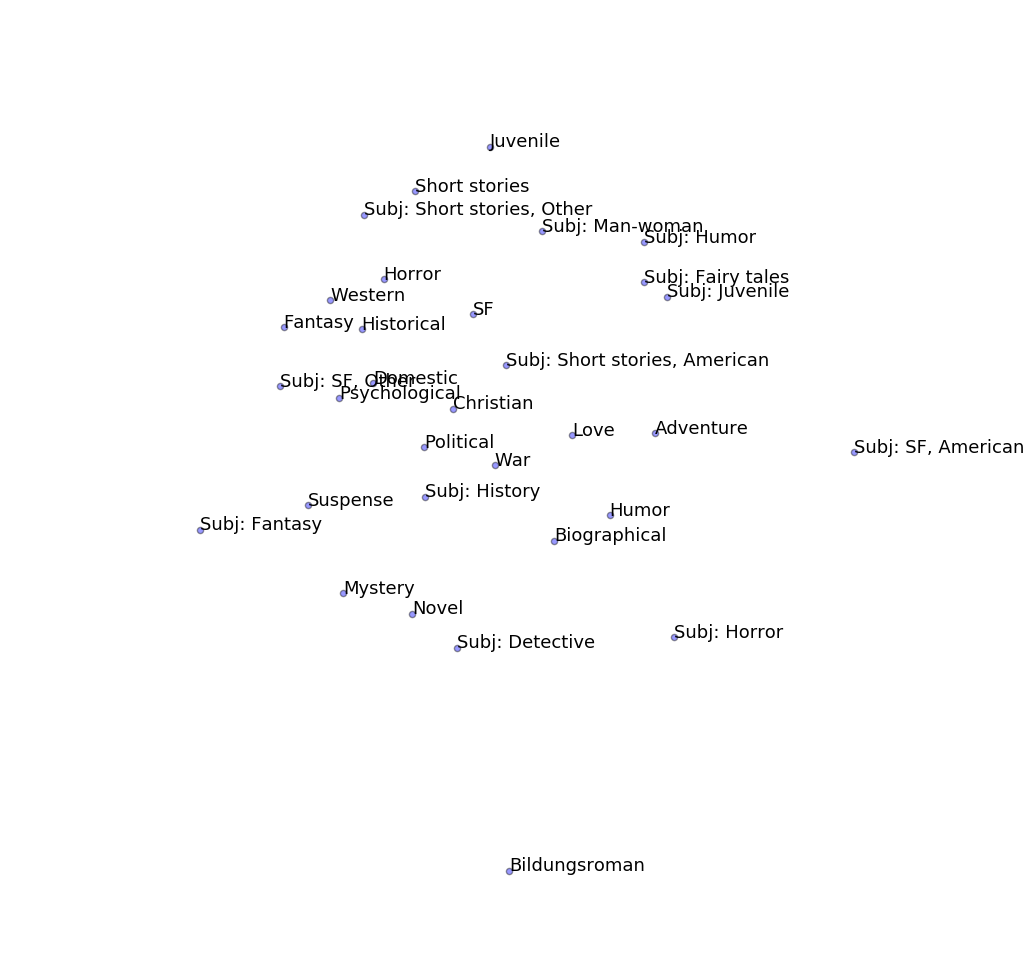

In [41]:
fig, ax = plt.subplots(figsize = (12, 12))
genres = primary_genres
colors=np.linspace(0, 1, 7)
ax.scatter(tfidf_coordinates[ :, 0], tfidf_coordinates[ : , 1], alpha = 0.4)

for i in range(len(genres)):
    thisx = tfidf_coordinates[i, 0]
    thisy = tfidf_coordinates[i, 1]
    name = genres[i]
    ax.annotate(name, (thisx + 0.07, thisy + 0.07), fontsize = 13)
    
plt.axis('off')
plt.show()

Does that make intuitive sense? What parts of it do or don't?

### 3.2 How strong is the correlation between social and textual similarity?

To calculate this we need to "unwrap" both matrices into vectors.

In [29]:
def compare_to_social(socialdf, otherdf):
    ''' Compares two DataFrames, ignoring cells as instructed,
    and exporting the results in two vectors for correlation.
    '''

    socialvals = []
    othervals = []
    comparisons = []
    
    indexlist = socialdf.index.tolist()

    for seq, idx1 in enumerate(indexlist):
        for idx2 in indexlist[seq + 1: ]:
            if idx1 not in otherdf.index or idx2 not in otherdf.index:
                continue
                
            otherval = otherdf.loc[idx1, idx2]
            if pd.isnull(otherval):
                continue
            else:
                sval = socialdf.loc[idx1, idx2]
                socialvals.append(sval)
                othervals.append(otherval)
                comparisons.append((idx1, idx2))
                
    return socialvals, othervals, comparisons

socialvals, tfidfvals, comparisons = compare_to_social(vizmatrix, tfidf_matrix)
print(pearsonr(socialvals, tfidfvals), 'n =', str(len(comparisons)))

(0.15291547445958364, 0.00063288820900801453) n = 496


## 4. Predictive models.

Let's try another way to measure the similarity between genres, using predictive models. This will have the advantage of ensuring that our measure of similarity is tightly tailored to the features that matter for a particular genre.

For instance, here's how we might measure the similarity of short stories and juvenile fiction: Model A learns to distinguish short stories from a random sample of fiction, distributed across the timeline in the same way the short stories are distributed. Model B learns to distinguish juvenile fiction from another random sample (with a different chronological distribution, matching the distribution of juvenile fiction). We use regularized logistic regression as a learning algorithm. The number of features and regularization constant are tuned by grid search.

Then we apply each model to the works used in the other, and compare the way they rank the books by probability of belonging to a or b. This produces two Spearman correlation coefficients; before they can be averaged, they need to undergo Fisher’s z-transformation—in effect, arctanh. So the distance d between a and b is

<img src="files/equation.png">

We're not going to train the models here because it takes the better part of a day even if we parallelize the calculation across multiple computers. Instead we'll load precalculated answers to the equation above, and use them to populate a 32 x 32 matrix.

In [42]:
pre_dict = dict()
for filepath in ['../results/overlapcrosscomparisons.tsv']:
    crosses = pd.read_csv(filepath, sep = '\t')
    for idx, row in crosses.iterrows():
        if row.testype.startswith('self'):
            continue
        g1 = row.name1.split('_')[0]
        g2 = row.name2.split('_')[0]

        if g1.startswith('random') or g2.startswith('random'):
            continue

        if g1 not in pre_dict:
            pre_dict[g1] = dict()

        if g2 not in pre_dict:
            pre_dict[g2] = dict()

        if g2 not in pre_dict[g1]:
            pre_dict[g1][g2] = [float(row.spearman)]
        else:
            pre_dict[g1][g2].append(float(row.spearman))

        if g1 not in pre_dict[g2]:
            pre_dict[g2][g1] = [float(row.spearman)]
        else:
            pre_dict[g2][g1].append(float(row.spearman))

avgsimilarities = dict()
for k1, v1 in pre_dict.items():
    avgsimilarities[k1] = dict()
    for k2, v2 in v1.items():
        avgsimilarities[k1][k2] = sum(v2) / len(v2)

Unfortunately there are some fiddly details here, having to do with the data format I used to save genre names.

In [36]:
def compress(aname):
    aname = aname.replace(':', '')
    aname = aname.replace(' ', '')
    aname = aname.replace(',', '')
    return aname

In [47]:
# Let's create a dict() that has the right names.

predictive = dict()

for g1 in primary_genres:
    if g1.startswith('random'):
        continue

    predictive[g1] = dict()
    
    for g2 in primary_genres:
        if g2.startswith('random'):
            continue
            
        if g1 == g2:
            predictive[g1][g1] = 0
            continue  
                
        else:
            withkey1 = compress(g1)
            withkey2 = compress(g2)

        if withkey1 in avgsimilarities and withkey2 in avgsimilarities[withkey1]:
            predictive[g1][g2] = avgsimilarities[withkey1][withkey2]
            
        else:
            predictive[g1][g2] = float('nan')
            print('error', g1, g2, withkey1, withkey2)      

Now convert the dictionary into a DataFrame.

In [49]:
predictive_matrix = pd.DataFrame(predictive)
predictive_matrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,0.000000,-0.089374,0.062906,-0.088186,-0.360672,0.445826,0.113316,0.541967,0.034001,0.183723,...,0.100743,0.149980,-0.433253,0.744202,0.875582,0.260021,-0.372226,0.800998,0.596862,0.661921
Bildungsroman,-0.089374,0.000000,-0.242454,-0.098786,0.573723,-0.265496,-0.268682,-0.002656,0.255883,0.022433,...,0.084803,0.174567,0.320883,-0.150948,-0.260595,0.382052,-0.252510,-0.031086,-0.271868,0.020310
Biographical,0.062906,-0.242454,0.000000,0.025658,-0.327723,0.536520,0.694278,0.096480,-0.427395,-0.179598,...,-0.271567,-0.238282,-0.304188,-0.043181,-0.089314,-0.041788,0.183456,-0.461443,0.394171,0.330647
Christian,-0.088186,-0.098786,0.025658,0.000000,0.270747,0.288671,0.276808,0.021624,-0.008394,0.357926,...,-0.353772,0.222926,0.118027,0.245135,0.099948,-0.141680,-0.407849,0.012638,-0.020547,0.271194
Domestic,-0.360672,0.573723,-0.327723,0.270747,0.000000,-0.467619,-0.171254,-0.184249,0.217702,0.185440,...,-0.069471,0.308703,0.527450,-0.255644,-0.462879,0.292616,-0.229332,-0.016491,-0.332612,0.002859
Fantasy,0.445826,-0.265496,0.536520,0.288671,-0.467619,0.000000,0.549064,0.752502,-0.312604,0.034995,...,-0.454329,-0.002955,-0.255082,0.960463,1.167167,-0.067549,-0.158386,-0.005233,0.460792,0.488347
Historical,0.113316,-0.268682,0.694278,0.276808,-0.171254,0.549064,0.000000,-0.025590,-0.510945,0.344883,...,-0.414515,0.328506,-0.367657,-0.141440,-0.126151,-0.131110,0.003690,-0.214186,0.459537,0.649634
Horror,0.541967,-0.002656,0.096480,0.021624,-0.184249,0.752502,-0.025590,0.000000,-0.087847,-0.117164,...,-0.260145,-0.142979,-0.184749,0.832844,0.934778,0.349977,-0.173057,0.479396,0.192900,0.378327
Humor,0.034001,0.255883,-0.427395,-0.008394,0.217702,-0.312604,-0.510945,-0.087847,0.000000,-0.091322,...,1.042515,-0.164752,0.291022,0.011838,-0.012730,-0.021625,-0.547463,0.203187,-0.361391,-0.310805
Juvenile,0.183723,0.022433,-0.179598,0.357926,0.185440,0.034995,0.344883,-0.117164,-0.091322,0.000000,...,0.220420,1.325600,-0.375056,0.012056,-0.012016,0.158342,-0.068255,0.027415,0.234068,0.362044


## 5. Questions to explore in workshop.

How strong is the correlation to social measures of proximity for this new measure of textual similarity?

This is not strictly speaking a distance metric. Can we nevertheless try visualizing it in a 2D map?